Lucas Henrique Nogueira - 202265515B


In [121]:
import numpy as np
from math import isfinite
import pandas as pd
import matplotlib.pyplot as plt
import os

# Questão 1

In [122]:
def f_ode(u, t, a):
    """f(u,t) = -a u (definição do PVI)."""
    return -a * u

def exact_solution(t, b, a):
    """Solução exata u(t) = b * exp(-a t)."""
    return b * np.exp(-a * t)

def theta_method(a, b, T, N, theta):
    """
    Método-theta
    """
    dt = T / float(N)
    t = np.linspace(0.0, T, N + 1)
    u_approx = np.zeros(N + 1)
    u_approx[0] = b

    # fator de amplificação para o caso linear
    amp_factor = (1.0 - a * dt * theta) / (1.0 + a * dt * (1.0 - theta))

    for n in range(N):
        u_approx[n+1] = amp_factor * u_approx[n]

    return t, u_approx

def leap_frog_method(a, b, T, N):
    """Diferença central (Leap-Frog) conforme slides."""
    dt = T / float(N)
    t = np.linspace(0.0, T, N + 1)
    u_approx = np.zeros(N + 1)
    u_approx[0] = b

    if N >= 1:
        u_approx[1] = b * (1.0 - a * dt)  # inicialização de passo 1 (explícita)

    for n in range(1, N):
        u_approx[n+1] = u_approx[n-1] - 2.0 * dt * a * u_approx[n]

    return t, u_approx

def rk2_midpoint_method(a, b, T, N):
    """Runge-Kutta de 2ª ordem (ponto médio) conforme slides."""
    dt = T / float(N)
    t = np.linspace(0.0, T, N + 1)
    u_approx = np.zeros(N + 1)
    u_approx[0] = b

    for n in range(N):
        k1 = f_ode(u_approx[n], t[n], a)
        k2 = f_ode(u_approx[n] + 0.5 * dt * k1, t[n] + 0.5 * dt, a)
        u_approx[n+1] = u_approx[n] + dt * k2

    return t, u_approx

def rk3_heun_method(a, b, T, N):
    """Runge-Kutta de 3ª ordem (Heun) conforme slides."""
    dt = T / float(N)
    t = np.linspace(0.0, T, N + 1)
    u_approx = np.zeros(N + 1)
    u_approx[0] = b

    for n in range(N):
        k1 = f_ode(u_approx[n], t[n], a)
        k2 = f_ode(u_approx[n] + (1/3) * dt * k1, t[n] + (1/3) * dt, a)
        k3 = f_ode(u_approx[n] + (2/3) * dt * k2, t[n] + (2/3) * dt, a)
        u_approx[n+1] = u_approx[n] + (dt / 4.0) * (k1 + 3.0 * k3)

    return t, u_approx

In [123]:
def get_stability_table(a, thetas):
    """
    Gera a tabela de condições de estabilidade.
    """
    rows = []

    for theta in thetas:
        method_name = ""
        if np.isclose(theta, 1.0):
            method_name = "Euler Explícito"
        elif np.isclose(theta, 0.5):
            method_name = "Crank-Nicolson"
        elif np.isclose(theta, 0.0):
            method_name = "Euler Implícito"

        # Condição de estabilidade
        if theta < 0.5:
            stability_cond = "Incondicionalmente Estável"
        elif np.isclose(theta, 0.5):
            # Para theta = 0.5, tratar como Crank-Nicolsonl
            dt_limit = 2.0 / a
            stability_cond = f"Δt < {dt_limit:.4f}"
        else:
            # Para theta > 0.5, condição Δt < 2 / (a * (2*theta - 1))
            dt_limit = 2.0 / (a * (2.0 * theta - 1.0)) if theta > 0.5 else np.inf
            stability_cond = f"Δt < {dt_limit:.4f}" if isfinite(dt_limit) else "Incondicionalmente Estável"

        rows.append({
            "θ": float(theta),
            "Método": method_name,
            "Condição de Estabilidade": stability_cond
        })

    return pd.DataFrame(rows)

def compute_convergence_data(a, b, T, N_list, methods_dict, exact_solution_func):
    """
    Calcula erros máximos (||e||_inf) e ajusta uma reta log-log para estimar p (taxa de convergência).
    """
    dt_list = [T / float(N) for N in N_list]
    errors = {name: [] for name in methods_dict.keys()}

    for N in N_list:
        for name, solver_func in methods_dict.items():
            t_num, u_num = solver_func(a, b, T, N)
            u_ex = exact_solution_func(t_num, b, a)
            error = np.max(np.abs(u_num - u_ex))
            errors[name].append(error)

    rates = {}

    for name, error_list in errors.items():
        safe_errors = np.maximum(error_list, 1e-16)
        slope = np.polyfit(np.log(dt_list), np.log(safe_errors), 1)[0]
        rates[name] = slope

    return dt_list, errors, rates

In [124]:
def plot_convergence(dt_list, errors, rates, title, filename=None, show=True):
    """
    Gera gráfico log-log de convergência.
    """
    plt.figure(figsize=(8, 6))

    for name, error_list in errors.items():
        p = rates.get(name, None)
        label = f'{name}  (p ≈ {p:.2f})' if p is not None else name
        plt.loglog(dt_list, error_list, 'o--', linewidth=1.3, markersize=6, label=label)

    plt.xlabel('Δt (passo de tempo)', fontsize=11)
    plt.ylabel('Erro máximo  ||e||∞', fontsize=11)
    plt.title(title, fontsize=12, weight='bold')
    plt.grid(True, which='both', ls='--', lw=0.5)
    plt.legend(fontsize=9)
    plt.tight_layout()

    if filename:
        filepath = os.path.join("figures", filename)
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()


Tabela de Estabilidade (θ de 0.0 a 1.0):
  θ          Método   Condição de Estabilidade
0.0 Euler Implícito Incondicionalmente Estável
0.1                 Incondicionalmente Estável
0.2                 Incondicionalmente Estável
0.3                 Incondicionalmente Estável
0.4                 Incondicionalmente Estável
0.5  Crank-Nicolson                Δt < 0.4000
0.6                                Δt < 2.0000
0.7                                Δt < 1.0000
0.8                                Δt < 0.6667
0.9                                Δt < 0.5000
1.0 Euler Explícito                Δt < 0.4000

ITEM (b)/(c) - Taxas de convergência estimadas (ajuste log-log):
Euler Implícito (θ=0.0)        p ≈ 0.9735
Crank-Nicolson (θ=0.5)         p ≈ 2.0015
Euler Explícito (θ=1.0)        p ≈ 1.0305
Diferença Central              p ≈ 1.9727
RK2 (Ponto Médio)              p ≈ 2.0503
RK3 (Heun)                     p ≈ 3.0521

Erros por N:
   N        dt  Euler Implícito (θ=0.0)  Crank-Nicolson (θ=0.5

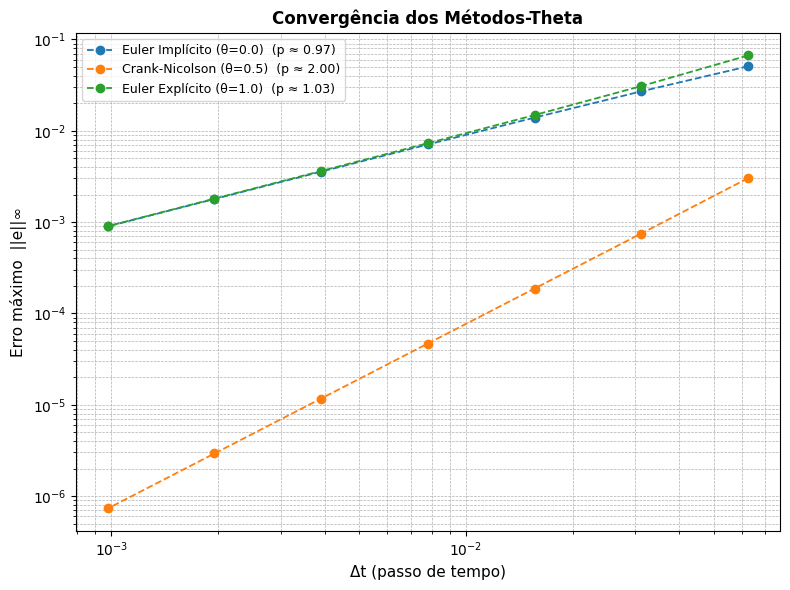

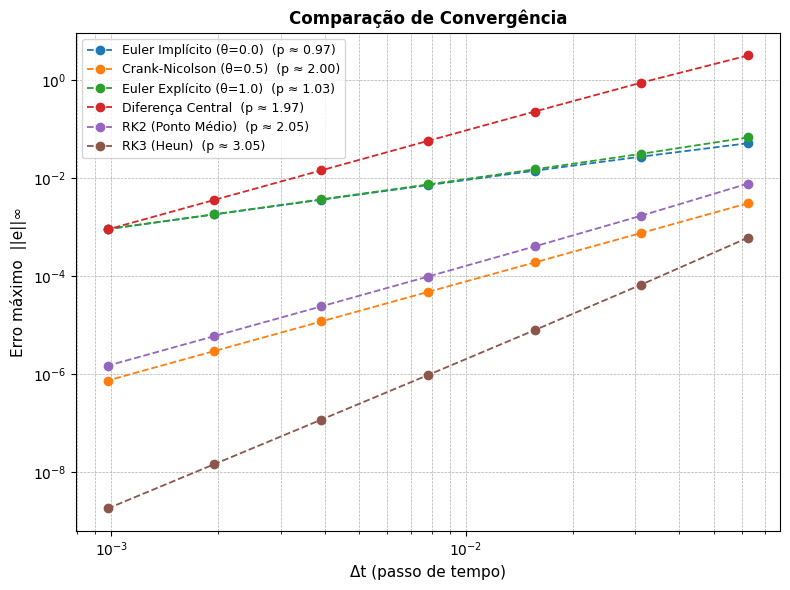

In [125]:
# Parâmetros
a = 5.0
b = 1.0
T = 1.0

# Refinamentos
N_list = [2**(j+1) for j in range(3, 10)]

# Métodos
all_methods = {
    "Euler Implícito (θ=0.0)": lambda a,b,T,N: theta_method(a,b,T,N,theta=0.0),
    "Crank-Nicolson (θ=0.5)": lambda a,b,T,N: theta_method(a,b,T,N,theta=0.5),
    "Euler Explícito (θ=1.0)": lambda a,b,T,N: theta_method(a,b,T,N,theta=1.0),
    "Diferença Central": leap_frog_method,
    "RK2 (Ponto Médio)": rk2_midpoint_method,
    "RK3 (Heun)": rk3_heun_method
}

# Item (a): Tabela de estabilidade
os.makedirs("figures", exist_ok=True)
thetas_to_analyze = np.round(np.arange(0.0, 1.01, 0.1), 2)
stability_df = get_stability_table(a, thetas=thetas_to_analyze)
print("\nTabela de Estabilidade (θ de 0.0 a 1.0):")
print(stability_df.to_string(index=False))

# Itens (b) e (c): convergência
dt_values, error_values, rate_values = compute_convergence_data(a, b, T, N_list, all_methods, exact_solution)

print("\nITEM (b)/(c) - Taxas de convergência estimadas (ajuste log-log):")

for name, rate in rate_values.items():
    print(f"{name:<30} p ≈ {rate:.4f}")

errors_df = pd.DataFrame({"N": N_list, "dt": dt_values})
for name, err_list in error_values.items():
    errors_df[name] = err_list

print("\nErros por N:")
print(errors_df.to_string(index=False, float_format="%.3e"))

# Gerar os gráficos de convergência
methods_b = {k: v for k, v in all_methods.items() if "θ" in k}
errors_b = {k: error_values[k] for k in methods_b}
rates_b = {k: rate_values[k] for k in methods_b}

plot_convergence(dt_values, errors_b, rates_b, title="Convergência dos Métodos-Theta", filename="item_b_convergence.png", show=True)
plot_convergence(dt_values, error_values, rate_values, title="Comparação de Convergência", filename="item_c_convergence.png", show=True)


Influência do parâmetro a:
        a  u(T) = b * exp(-a*T)
 1.000000              0.367879
 5.000000              0.006738
10.000000              0.000045


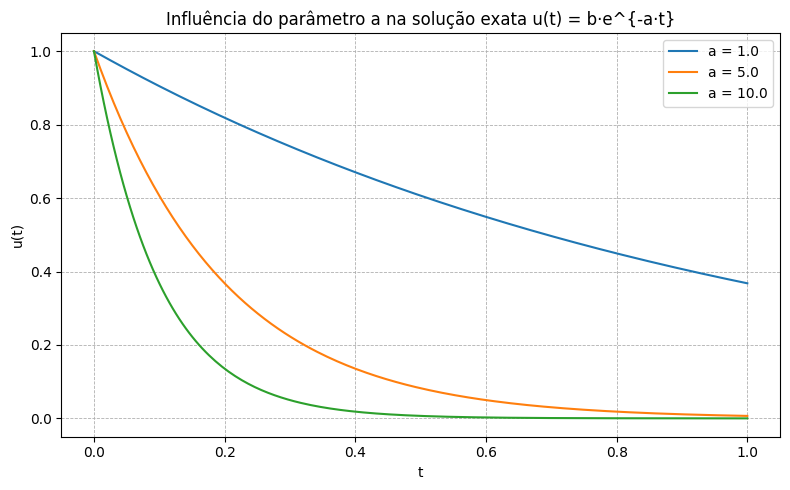


Escolhas de Δt (T/N):
   N           Δt
  16 6.250000e-02
  32 3.125000e-02
  64 1.562500e-02
 128 7.812500e-03
 256 3.906250e-03
 512 1.953125e-03
1024 9.765625e-04


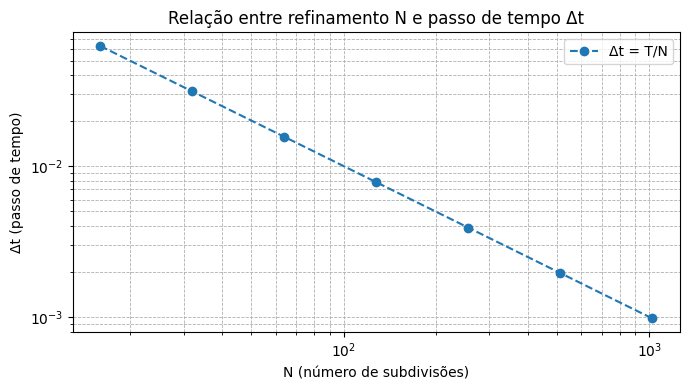


Erro ao longo do tempo (N=64):
        t  Euler Implícito (θ=0.0)  Crank-Nicolson (θ=0.5)  Euler Explícito (θ=1.0)
0.000e+00                0.000e+00               0.000e+00                0.000e+00
1.562e-02                2.687e-03               3.678e-05                2.974e-03
3.125e-02                4.978e-03               6.804e-05                5.492e-03
4.688e-02                6.916e-03               9.438e-05                7.606e-03
6.250e-02                8.541e-03               1.164e-04                9.365e-03
7.812e-02                9.888e-03               1.345e-04                1.081e-02
9.375e-02                1.099e-02               1.493e-04                1.198e-02
1.094e-01                1.188e-02               1.611e-04                1.290e-02
1.250e-01                1.257e-02               1.703e-04                1.361e-02
1.406e-01                1.310e-02               1.772e-04                1.414e-02
1.562e-01                1.348e-02          

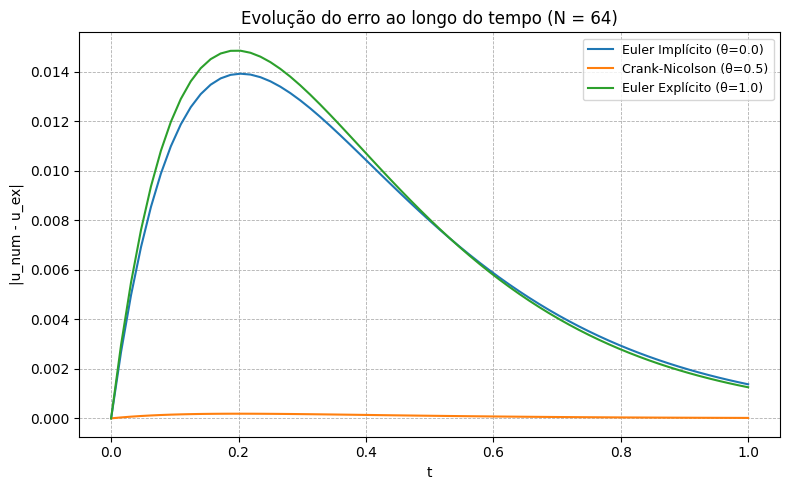

In [126]:
# =============================================================
# Influência do parâmetro a
# =============================================================
a_values = [1.0, 5.0, 10.0]
T = 1.0
b = 1.0

# Tabela numérica
influence_a_df = pd.DataFrame({
    "a": a_values,
    "u(T) = b * exp(-a*T)": [b * np.exp(-a * T) for a in a_values]
})

print("\nInfluência do parâmetro a:")
print(influence_a_df.to_string(index=False, float_format="%.6f"))

# Gráfico - u(t) = b e^{-a t} para diferentes valores de a
t = np.linspace(0, T, 200)
plt.figure(figsize=(8,5))

for a_val in a_values:
    plt.plot(t, b*np.exp(-a_val*t), label=f"a = {a_val}")

plt.xlabel("t")
plt.ylabel("u(t)")
plt.title("Influência do parâmetro a na solução exata u(t) = b·e^{-a·t}")
plt.grid(True, ls='--', lw=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("figures/influencia_a.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# ===========================================================
# Justificativa da escolha de Δt (T/N)
# ===========================================================
N_list = [2**(j+1) for j in range(3, 10)]   # 16..1024
dt_list = [T / float(N) for N in N_list]

dt_df = pd.DataFrame({"N": N_list, "Δt": dt_list})
print("\nEscolhas de Δt (T/N):")
print(dt_df.to_string(index=False, float_format="%.6e"))

# Gráfico - Δt versus N (escala log-log)
plt.figure(figsize=(7,4))
plt.loglog(N_list, dt_list, 'o--', label="Δt = T/N")
plt.xlabel("N (número de subdivisões)")
plt.ylabel("Δt (passo de tempo)")
plt.title("Relação entre refinamento N e passo de tempo Δt")
plt.grid(True, which="both", ls="--", lw=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("figures/dt_choices.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# ===========================================================
# Erro ao longo do tempo para N fixo (ex: N=64)
# ===========================================================
N_check = 64
a = 5.0
b = 1.0
T = 1.0

methods_to_check = {
    "Euler Implícito (θ=0.0)": lambda a,b,T,N: theta_method(a,b,T,N,theta=0.0),
    "Crank-Nicolson (θ=0.5)": lambda a,b,T,N: theta_method(a,b,T,N,theta=0.5),
    "Euler Explícito (θ=1.0)": lambda a,b,T,N: theta_method(a,b,T,N,theta=1.0)
}

# Tabela de erro |u_num - u_ex| por tempo
error_time_df = pd.DataFrame()
for name, func in methods_to_check.items():
    t_num, u_num = func(a,b,T,N_check)
    u_ex = exact_solution(t_num, b, a)
    error_time_df["t"] = t_num
    error_time_df[name] = np.abs(u_num - u_ex)

print(f"\nErro ao longo do tempo (N={N_check}):")
print(error_time_df.to_string(index=False, float_format="%.3e"))

# Gráfico - Erro ao longo do tempo
plt.figure(figsize=(8,5))
for name in methods_to_check.keys():
    plt.plot(error_time_df["t"], error_time_df[name], label=name)
plt.xlabel("t")
plt.ylabel("|u_num - u_ex|")
plt.title(f"Evolução do erro ao longo do tempo (N = {N_check})")
plt.grid(True, ls='--', lw=0.6)
plt.legend(fontsize=9)
plt.tight_layout()
plt.savefig("figures/erro_no_tempo.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

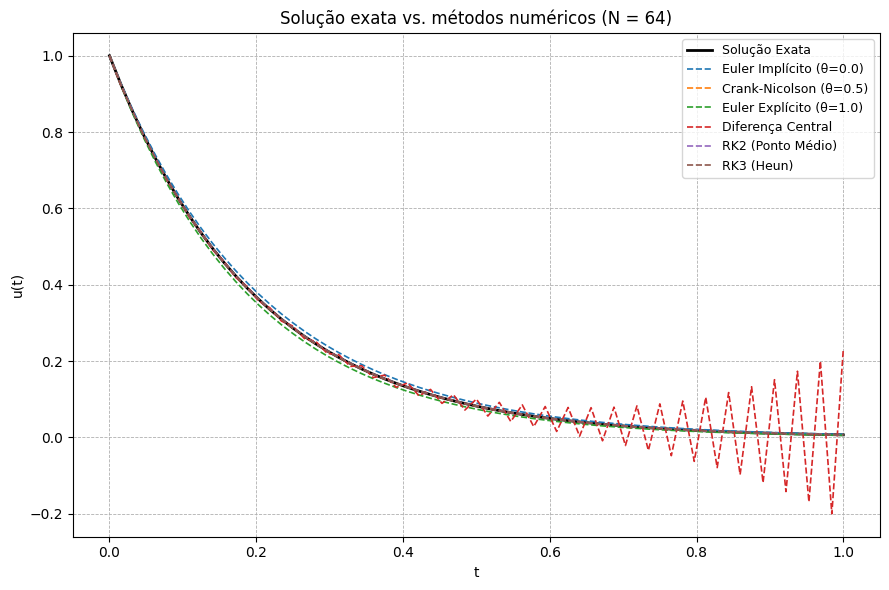


Comparação do valor final u(T):
                 Método     u(T)
                  Exata 0.006738
Euler Implícito (θ=0.0) 0.008113
 Crank-Nicolson (θ=0.5) 0.006721
Euler Explícito (θ=1.0) 0.005483
      Diferença Central 0.231050
      RK2 (Ponto Médio) 0.006774
             RK3 (Heun) 0.006737


In [127]:
# Solucao Exata
a = 5.0
b = 1.0
T = 1.0
N_plot = 64

# Define todos os métodos
all_methods = {
    "Euler Implícito (θ=0.0)": lambda a,b,T,N: theta_method(a,b,T,N,theta=0.0),
    "Crank-Nicolson (θ=0.5)": lambda a,b,T,N: theta_method(a,b,T,N,theta=0.5),
    "Euler Explícito (θ=1.0)": lambda a,b,T,N: theta_method(a,b,T,N,theta=1.0),
    "Diferença Central": leap_frog_method,
    "RK2 (Ponto Médio)": rk2_midpoint_method,
    "RK3 (Heun)": rk3_heun_method
}

# Computa solução exata
t = np.linspace(0.0, T, N_plot + 1)
u_ex = exact_solution(t, b, a)

# Armazena soluções numéricas
u_approx_dict = {}
for name, solver_func in all_methods.items():
    t_num, u_num = solver_func(a, b, T, N_plot)
    u_approx_dict[name] = u_num

# Gera o gráfico
plt.figure(figsize=(9,6))
plt.plot(t, u_ex, 'k-', linewidth=2.0, label="Solução Exata")

for name, u_num in u_approx_dict.items():
    plt.plot(t, u_num, '--', linewidth=1.2, label=name)

plt.xlabel("t")
plt.ylabel("u(t)")
plt.title(f"Solução exata vs. métodos numéricos (N = {N_plot})")
plt.grid(True, ls='--', lw=0.6)
plt.legend(fontsize=9)
plt.tight_layout()
plt.savefig("figures/solution_vs_exact_all_methods.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

final_values = {"Método": ["Exata"] + list(u_approx_dict.keys()),
                "u(T)": [u_ex[-1]] + [u[-1] for u in u_approx_dict.values()]}

final_df = pd.DataFrame(final_values)
print("\nComparação do valor final u(T):")
print(final_df.to_string(index=False, float_format="%.6f"))

# Questão 2

In [128]:
def exact_solution(t, alpha, beta):
    """
    Solução exata aproximada do pêndulo linearizado:
        sen(u) ≈ u  →  u'' + u = 0
    => u(t) = α cos(t) + β sin(t)
    """
    return alpha * np.cos(t) + beta * np.sin(t)

def rk4_reference(alpha, beta, T, N_ref=2**14):
    """
    Solução de referência numérica para o pêndulo não linear:
    integra o sistema u' = v, v' = -sin(u) com passo muito pequeno (RK4).
    """
    dt = T / float(N_ref)
    t = np.linspace(0.0, T, N_ref + 1)
    u = np.zeros(N_ref + 1)
    v = np.zeros(N_ref + 1)

    u[0] = alpha
    v[0] = beta

    for n in range(N_ref):
        k1u = v[n]
        k1v = -np.sin(u[n])

        k2u = v[n] + 0.5*dt*k1v
        k2v = -np.sin(u[n] + 0.5*dt*k1u)

        k3u = v[n] + 0.5*dt*k2v
        k3v = -np.sin(u[n] + 0.5*dt*k2u)

        k4u = v[n] + dt*k3v
        k4v = -np.sin(u[n] + dt*k3u)

        u[n+1] = u[n] + (dt/6.0)*(k1u + 2*k2u + 2*k3u + k4u)
        v[n+1] = v[n] + (dt/6.0)*(k1v + 2*k2v + 2*k3v + k4v)

    return t, u

def central_second_order_linear(alpha, beta, T, N):
    """
    Versão linearizada: substitui sin(u) por u.
    Discretização direta da EDO u'' = -u
    """
    dt = T / float(N)
    t = np.linspace(0.0, T, N + 1)
    u = np.zeros(N + 1)

    # Condições iniciais
    u[0] = alpha
    u[1] = u[0] + dt * beta + 0.5 * dt**2 * (-u[0])

    for n in range(1, N):
        u[n+1] = 2*u[n] - u[n-1] + dt**2 * (-u[n])

    return t, u

def central_second_order_nonlinear(alpha, beta, T, N):
    """
    Versão não linear: usa o termo -sin(u_n) diretamente.
    """
    dt = T / float(N)
    t = np.linspace(0.0, T, N + 1)
    u = np.zeros(N + 1)

    # Condições iniciais (com u''(0) = -sin(u0))
    u[0] = alpha
    u[1] = u[0] + dt * beta + 0.5 * dt**2 * (-np.sin(u[0]))

    for n in range(1, N):
        u[n+1] = 2*u[n] - u[n-1] + dt**2 * (-np.sin(u[n]))

    return t, u


def crank_nicolson_linear(alpha, beta, T, N):
    """
    Versão linearizada do Crank–Nicolson:
        u' = v
        v' = -u
    Resulta em sistema 2x2
    """
    dt = T / float(N)
    t = np.linspace(0.0, T, N + 1)
    u = np.zeros(N + 1)
    v = np.zeros(N + 1)

    u[0] = alpha
    v[0] = beta

    for n in range(N):
        # Montagem do sistema:
        # [1, -dt/2] [u_{n+1}] = [u_n + (dt/2) v_n]
        # [dt/2, 1 ] [v_{n+1}]   [v_n - (dt/2) u_n]
        a11, a12 = 1.0, -0.5 * dt
        a21, a22 = 0.5 * dt, 1.0
        b1 = u[n] + 0.5 * dt * v[n]
        b2 = v[n] - 0.5 * dt * u[n]

        # Solução analítica do sistema 2x2
        det = a11 * a22 - a12 * a21
        u_next = (b1 * a22 - b2 * a12) / det
        v_next = (a11 * b2 - a21 * b1) / det

        u[n+1] = u_next
        v[n+1] = v_next

    return t, u

def crank_nicolson_nonlinear(alpha, beta, T, N, tol=1e-10, max_iter=30):
    """
    Versão não linear do Crank–Nicolson:
        v' = -sin(u)
    Resolvido via Newton (2x2) em cada passo de tempo.
    """
    dt = T / float(N)
    t = np.linspace(0.0, T, N + 1)
    u = np.zeros(N + 1)
    v = np.zeros(N + 1)

    u[0] = alpha
    v[0] = beta

    for n in range(N):
        # Chute inicial com Euler explícito
        u_next = u[n] + dt * v[n]
        v_next = v[n] - dt * np.sin(u[n])

        for _ in range(max_iter):
            sin_un = np.sin(u[n])
            sin_unext = np.sin(u_next)
            cos_unext = np.cos(u_next)

            # Resíduos do sistema F(u_{n+1}, v_{n+1}) = 0
            F1 = u_next - u[n] - 0.5 * dt * (v[n] + v_next)
            F2 = v_next - v[n] - 0.5 * dt * (-sin_un - sin_unext)

            # Jacobiano analítico 2x2
            J11, J12 = 1.0, -0.5 * dt
            J21, J22 = 0.5 * dt * cos_unext, 1.0

            # Resolução manual do sistema linear J·Δ = -F
            detJ = J11 * J22 - J12 * J21
            du = (-F1 * J22 - (-F2) * J12) / detJ
            dv = (J11 * (-F2) - J21 * (-F1)) / detJ

            # Atualiza aproximações
            u_next += du
            v_next += dv

            # Critério de convergência
            if max(abs(du), abs(dv)) < tol:
                break

        u[n+1] = u_next
        v[n+1] = v_next

    return t, u


In [129]:
def compute_convergence_data_pendulum(alpha, beta, T, N_list, methods_dict):
    """
    Calcula erro máximo ||e||_∞ e taxa de convergência p ≈ slope(log-log)
    Para métodos não lineares, compara com solução de referência RK4.
    """
    dt_list = [T / float(N) for N in N_list]
    errors = {name: [] for name in methods_dict.keys()}

    # Solução de referência RK4 (não linear)
    t_ref, u_ref = rk4_reference(alpha, beta, T, N_ref=2**14)

    for N in N_list:
        for name, solver in methods_dict.items():
            t_num, u_num = solver(alpha, beta, T, N)

            # Escolhe a "solução exata" conforme o tipo de método
            if "não linear" in name:
                u_ex = np.interp(t_num, t_ref, u_ref)  # interpola a referência RK4
            else:
                u_ex = exact_solution(t_num, alpha, beta)

            err = np.max(np.abs(u_num - u_ex))
            errors[name].append(err)

    # Estima p a partir do ajuste log-log
    rates = {}

    for name, err in errors.items():
        safe_err = np.maximum(err, 1e-16)
        slope = np.polyfit(np.log(dt_list), np.log(safe_err), 1)[0]
        rates[name] = slope

    return dt_list, errors, rates

In [130]:
def plot_solution_comparison(alpha, beta, T, N_plot, save_path="figures/solution_comparison.png"):
    """Gráfico da solução exata (linear) e referência RK4 (não linear) vs métodos numéricos."""
    # Solução exata (linear)
    t_ex = np.linspace(0.0, T, N_plot + 1)
    u_ex = exact_solution(t_ex, alpha, beta)

    # Solução de referência não-linear (RK4 refinada)
    t_ref, u_ref = rk4_reference(alpha, beta, T, N_ref=2**14)
    u_ref_interp = np.interp(t_ex, t_ref, u_ref)

    # Soluções numéricas
    t_dc_lin, u_dc_lin = central_second_order_linear(alpha, beta, T, N_plot)
    t_dc_non, u_dc_non = central_second_order_nonlinear(alpha, beta, T, N_plot)
    t_cn_lin, u_cn_lin = crank_nicolson_linear(alpha, beta, T, N_plot)
    t_cn_non, u_cn_non = crank_nicolson_nonlinear(alpha, beta, T, N_plot)

    plt.figure(figsize=(10,6))
    plt.plot(t_ex, u_ex, 'k-', linewidth=2, label='Solução exata (linear)')
    plt.plot(t_ex, u_ref_interp, 'r-', linewidth=1.5, label='Solução de referência (RK4 não linear)')
    plt.plot(t_dc_lin, u_dc_lin, '--', label='DC - linear')
    plt.plot(t_dc_non, u_dc_non, ':', label='DC - não linear')
    plt.plot(t_cn_lin, u_cn_lin, '-.', label='CN - linear')
    plt.plot(t_cn_non, u_cn_non, '--', label='CN - não linear')
    plt.xlabel("t")
    plt.ylabel("u(t)")
    plt.title(f"Solução exata e referência RK4 vs métodos numéricos (N = {N_plot})")
    plt.legend()
    plt.grid(ls='--', lw=0.5)
    plt.tight_layout()

    os.makedirs("figures", exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()


def plot_convergence_loglog(dt_values, errors, rates, save_path="figures/convergence_loglog.png"):
    """Gráfico de convergência (log-log) do erro máximo ||e||∞."""
    plt.figure(figsize=(8,6))
    markers = ['o','s','^','d']
    for i, (name, err_list) in enumerate(errors.items()):
        p = rates[name]
        plt.loglog(dt_values, err_list, marker=markers[i], linestyle='--',
                   label=f"{name} (p ≈ {p:.2f})")

    plt.xlabel("Δt (passo de tempo)")
    plt.ylabel("Erro máximo ||e||∞")
    plt.title("Convergência log-log dos métodos (linear x não linear)")
    plt.grid(True, which='both', ls='--', lw=0.5)
    plt.legend()
    plt.tight_layout()

    os.makedirs("figures", exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()


def plot_error_over_time(alpha, beta, T, N_plot, save_path="figures/error_over_time.png"):
    """Gráfico da evolução do erro ao longo do tempo."""
    t_ex = np.linspace(0.0, T, N_plot + 1)
    u_ex = exact_solution(t_ex, alpha, beta)
    t_ref, u_ref = rk4_reference(alpha, beta, T, N_ref=2**14)
    u_ref_interp = np.interp(t_ex, t_ref, u_ref)

    _, u_dc_lin = central_second_order_linear(alpha, beta, T, N_plot)
    _, u_dc_non = central_second_order_nonlinear(alpha, beta, T, N_plot)
    _, u_cn_lin = crank_nicolson_linear(alpha, beta, T, N_plot)
    _, u_cn_non = crank_nicolson_nonlinear(alpha, beta, T, N_plot)

    plt.figure(figsize=(9,5))
    plt.plot(t_ex, np.abs(u_dc_lin - u_ex), label='|erro| DC linear')
    plt.plot(t_ex, np.abs(u_dc_non - u_ref_interp), label='|erro| DC não linear (vs RK4)')
    plt.plot(t_ex, np.abs(u_cn_lin - u_ex), label='|erro| CN linear')
    plt.plot(t_ex, np.abs(u_cn_non - u_ref_interp), label='|erro| CN não linear (vs RK4)')
    plt.xlabel("t")
    plt.ylabel("|u_num - u_ref|")
    plt.title(f"Evolução temporal do erro (N = {N_plot})")
    plt.legend()
    plt.grid(ls='--', lw=0.5)
    plt.tight_layout()

    os.makedirs("figures", exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()


=== TABELA DE ERROS (||e||∞) ===
   N        Δt  DC - linear (sin≈u)  DC - não linear (sin(u))  CN - linear (sin≈u)  CN - não linear (sin(u))
  16 3.927e-01            4.189e-03                 4.160e-03            7.885e-03                 7.874e-03
  32 1.963e-01            1.019e-03                 1.012e-03            2.007e-03                 2.004e-03
  64 9.817e-02            2.529e-04                 2.512e-04            5.039e-04                 5.033e-04
 128 4.909e-02            6.312e-05                 6.268e-05            1.261e-04                 1.260e-04
 256 2.454e-02            1.577e-05                 1.566e-05            3.154e-05                 3.150e-05
 512 1.227e-02            3.943e-06                 3.916e-06            7.885e-06                 7.875e-06
1024 6.136e-03            9.857e-07                 9.789e-07            1.971e-06                 1.969e-06

=== TAXAS DE CONVERGÊNCIA (p ≈ slope log-log) ===
DC - linear (sin≈u)            p ≈ 2.0068
D

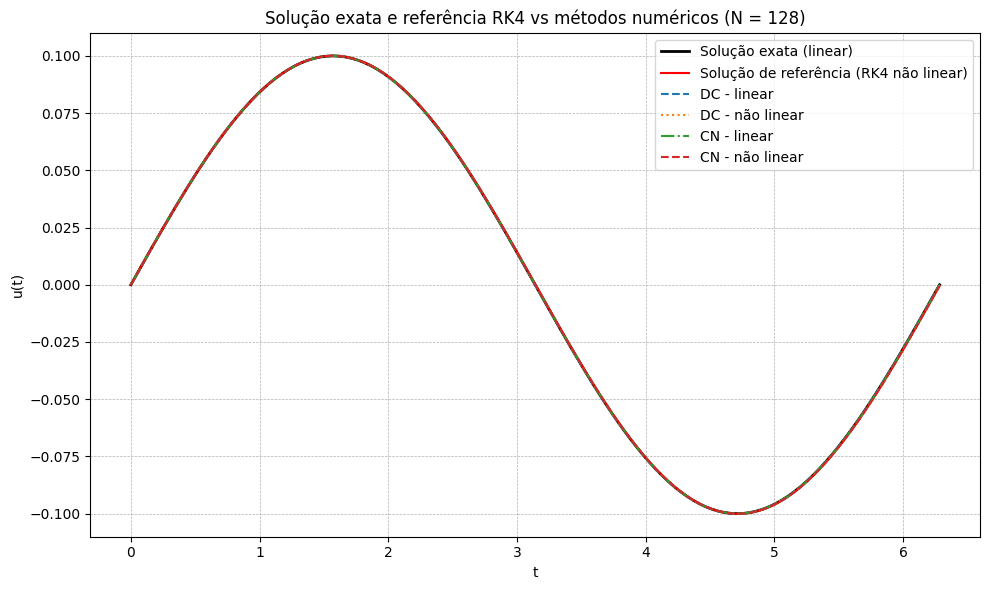

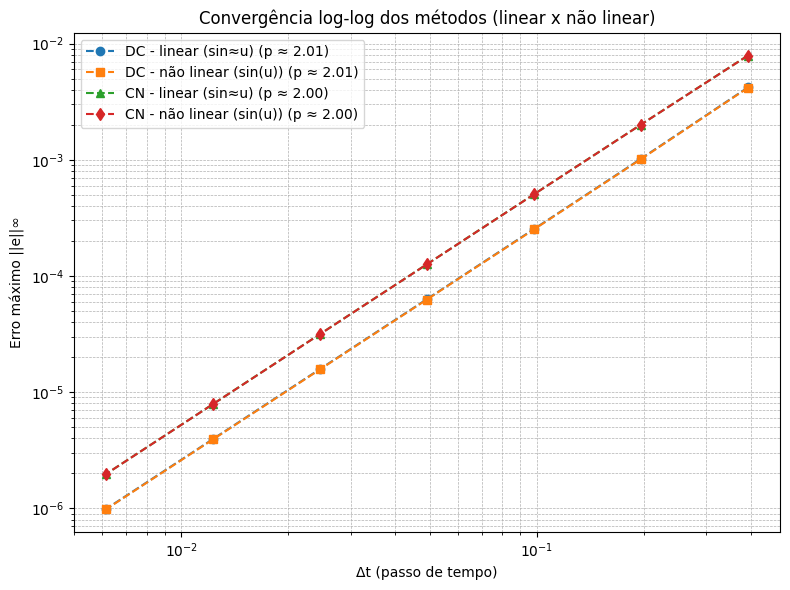

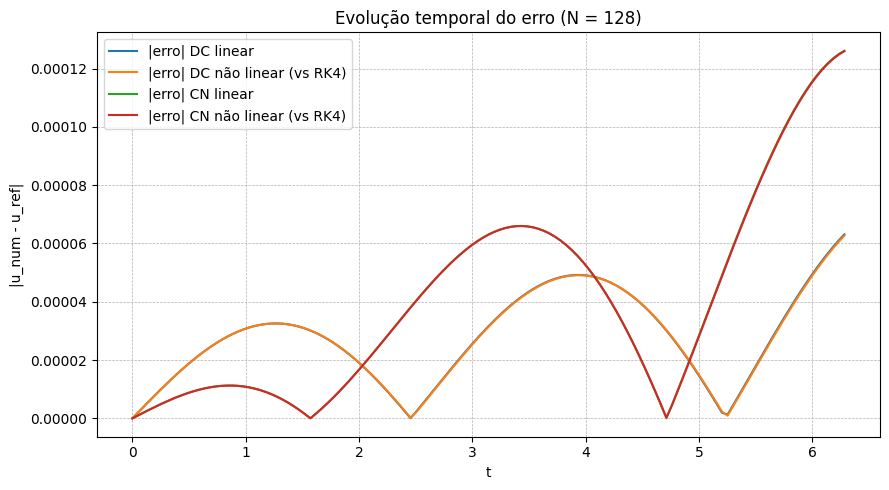

In [131]:
# Parâmetros do problema
alpha = 0.0
beta = 0.1
T = 2.0 * np.pi
N_list = [2**(j+1) for j in range(3, 10)]  # 16, 32, 64, 128, 256, 512, 1024

methods = {
    "DC - linear (sin≈u)": central_second_order_linear,
    "DC - não linear (sin(u))": central_second_order_nonlinear,
    "CN - linear (sin≈u)": crank_nicolson_linear,
    "CN - não linear (sin(u))": crank_nicolson_nonlinear
}

dt_values, errors, rates = compute_convergence_data_pendulum(alpha, beta, T, N_list, methods)

df = pd.DataFrame({"N": N_list, "Δt": dt_values})
for name, err_list in errors.items():
    df[name] = err_list

print("\n=== TABELA DE ERROS (||e||∞) ===")
print(df.to_string(index=False, float_format="%.3e"))

print("\n=== TAXAS DE CONVERGÊNCIA (p ≈ slope log-log) ===")
for name, p in rates.items():
    print(f"{name:<30} p ≈ {p:.4f}")

# Gráficos
N_plot = 128
plot_solution_comparison(alpha, beta, T, N_plot)
plot_convergence_loglog(dt_values, errors, rates)
plot_error_over_time(alpha, beta, T, N_plot)